# Data Loading

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gdown
import zipfile
from tqdm import tqdm 

In [ ]:
gdown.download('https://drive.google.com/uc?export=download&id=1XYraKEO6YiW2YQldhwjc7Mt94VZOvhKk', 'dataset.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1XYraKEO6YiW2YQldhwjc7Mt94VZOvhKk
To: /content/dataset.zip
100%|██████████| 2.99G/2.99G [00:38<00:00, 76.6MB/s]


'dataset.zip'

In [ ]:
with zipfile.ZipFile('dataset.zip', mode='r') as zip_file:
    for zf in tqdm(zip_file.infolist(), desc="Extracting"):
        try:
            zip_file.extract(zf)                
        except Exception as e:
            print(e)
zip_file.close()

Extracting: 100%|██████████| 2939/2939 [01:08<00:00, 42.76it/s] 


# Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Split Data

In [ ]:
def split_data(data, train_size=0.8, random_seed=42):

    """Fungsi ini untuk memisahkan data menjadi train set dan validation_set
    dengan urutan hasil return : data_train, data_validasi"""
    np.random.seed(int(random_seed))
    test_size=1-train_size
    panjang_train = int(train_size*len(data))
    panjang_val = int(test_size*len(data))
    selisih =len(data) - (panjang_train + panjang_val)
    # print(len(data), " - ( ",panjang_train, " + ", panjang_val," ) = ",selisih)
    if selisih > 0:
        panjang_train +=selisih
    
    data_train = []
    #memilih data train dari data
    while len(data_train) != panjang_train:
        bantu = np.random.randint(0, (len(data)-1))
        if data[bantu] not in data_train:
            data_train.append(data[bantu])
            del data[bantu]
     
    #Sisanya Dicopy kedalam Train
    data_validasi = data.copy()
    del data
     
    print("\nPanjang train : ",panjang_train)
    print("Panjang validasi : ",panjang_val,"\n")
    return data_train, data_validasi

In [ ]:
#Selanjutnya pindahkan ke folder terpisah

#Membuat fungsi untuk membuat folder penyimpanan dan memindahkan data yang telah dipisahkan kedalam folder tersebut
def move(data_train, data_val, data_path, train_path, val_path):
    """Fungsi ini untuk membuat folder penyimpanan dan 
    memasukan data yang telah dipisahkan dengan folder tersebut"""
    
    #Memeriksa apakan folder sudah ada, jika belum maka tambahkan folder
    if not (os.path.exists(train_path) and os.path.exists(val_path)):
        os.makedirs(train_path)
        os.makedirs(val_path)
    else:
        print('Folder Sudah ada')
    
    #memindahkan ke folder terpisah
    for i in range(len(data_train)):
        shutil.move(os.path.join(data_path, data_train[i]), os.path.join(train_path, data_train[i]))
    
    #memindahkan ke folder terpisah
    for i in range(len(data_val)):
        shutil.move(os.path.join(data_path, data_val[i]), os.path.join(val_path, data_val[i]))

In [ ]:
def split_and_move_data(path='', random_seed=42, train_size=0.8):
    path_dict = {}
    for i in os.listdir(path):
        path_dict[i] = os.listdir(os.path.join(path, i))
        print(i, "=> sebanyak ", len(os.listdir(os.path.join(path, i))))
      
    dict_train_test = {}
    for cls in path_dict.keys():
        dict_train_test[cls] = split_data(path_dict[cls],random_seed=random_seed,train_size=train_size)
     
    for cls in path_dict.keys():
        move(
           data_train =  dict_train_test[cls][0],
           data_val = dict_train_test[cls][1],
           data_path = os.path.join(path, cls),
           train_path = os.path.join(os.path.join(path,'train'),cls),
           val_path = os.path.join(os.path.join(path,'test'),cls)
        )
        shutil.rmtree(os.path.join(path, cls))
    len_train = 0
    len_test = 0
    train = os.path.join(path,'train')
    test = os.path.join(path,'test')
    for cls in os.listdir(train):
        len_train += len(os.listdir((os.path.join(train,cls))))
        len_test += len(os.listdir((os.path.join(test,cls))))
         
     
    print('train : {} data'.format(len_train))
    print('test  : {} data'.format(len_test))      

In [ ]:
split_and_move_data('/content/content/dataset', train_size=0.85)

bika_ambon => sebanyak  270
putu_ayu => sebanyak  266
cucur => sebanyak  240
klepon => sebanyak  234
kue_sus => sebanyak  198
kue_pukis => sebanyak  304
kue_cubit => sebanyak  238
kue_lupis => sebanyak  317
dadar_gulung => sebanyak  309
onde_onde => sebanyak  287
data_selain_kue => sebanyak  264

Panjang train :  230
Panjang validasi :  40 


Panjang train :  227
Panjang validasi :  39 


Panjang train :  204
Panjang validasi :  36 


Panjang train :  199
Panjang validasi :  35 


Panjang train :  169
Panjang validasi :  29 


Panjang train :  259
Panjang validasi :  45 


Panjang train :  203
Panjang validasi :  35 


Panjang train :  270
Panjang validasi :  47 


Panjang train :  263
Panjang validasi :  46 


Panjang train :  244
Panjang validasi :  43 


Panjang train :  225
Panjang validasi :  39 

train : 2493 data
test  : 434 data


# Data Generator

In [ ]:
train_dir = '/content/content/dataset/train'
test_dir = '/content/content/dataset/test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[0.6, 1.5],
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(
                  rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=True
)


test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=434,
    class_mode='categorical'
)

Found 2493 images belonging to 11 classes.
Found 434 images belonging to 11 classes.


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
model = load_model('/content/drive/MyDrive/Orbit_final_project/MODEL/model_projek_mobileNetPart3')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
inputs = model.input
feature_extraction = model.layers[-5].output
gap = GlobalAveragePooling2D()(feature_extraction)
feature_extractor = Model(inputs, gap)
feature_extractor.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
newModel = Sequential([
        feature_extractor,
        Dense(1024, activation=LeakyReLU(0.5), kernel_regularizer=l2(0.001), kernel_initializer='he_normal', name='dense_1'),
        Dropout(0.5, name='dropout_1'),
        BatchNormalization(),
        Dense(1024, activation=LeakyReLU(0.5), kernel_regularizer=l2(0.001), kernel_initializer='he_normal', name='dense_2'),
        Dropout(0.5, name='dropout_2'),
        BatchNormalization(),
        Dense(11, activation='softmax', name='final_output')
])
newModel.layers[0]._name = 'feature_extractor'
newModel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (Function  (None, 1024)             3228864   
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_18 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)             

In [ ]:
newModel.layers[0].trainable = False
newModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
def checkpoint(filepath, monitor='val_loss'):
    return ModelCheckpoint(filepath=filepath, monitor=monitor, verbose=1, save_best_only=False, save_freq='epoch')

In [ ]:
model_checkpoint = checkpoint('/content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_{epoch:02d}', monitor='val_accuracy',)
learningrate_decay = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                       patience=10, verbose=1, min_lr=1e-20)
earlystopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = test_generator.n // test_generator.batch_size
print(train_steps_per_epoch, val_steps) 

19 1


# Transfer Learning

In [57]:
history = newModel.fit(train_generator, validation_data=test_generator, epochs=100,
          verbose=1, callbacks=[model_checkpoint, learningrate_decay, earlystopping],
          steps_per_epoch=train_steps_per_epoch, validation_steps=val_steps)

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 5.2608 - accuracy: 0.6249
Epoch 00001: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_01


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_01/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_01/assets


19/19 [==============================] - 245s 13s/step - loss: 5.2608 - accuracy: 0.6249 - val_loss: 5.0684 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 4.4509 - accuracy: 0.8397
Epoch 00002: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_02


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_02/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_02/assets


19/19 [==============================] - 213s 11s/step - loss: 4.4509 - accuracy: 0.8397 - val_loss: 4.4188 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 4.1959 - accuracy: 0.8647
Epoch 00003: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_03


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_03/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_03/assets


19/19 [==============================] - 213s 11s/step - loss: 4.1959 - accuracy: 0.8647 - val_loss: 4.1593 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 3.9400 - accuracy: 0.8888
Epoch 00004: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_04


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_04/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_04/assets


19/19 [==============================] - 212s 11s/step - loss: 3.9400 - accuracy: 0.8888 - val_loss: 3.9365 - val_accuracy: 0.8825 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - ETA: 0s - loss: 3.7278 - accuracy: 0.8998
Epoch 00005: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_05


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_05/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_05/assets


19/19 [==============================] - 211s 11s/step - loss: 3.7278 - accuracy: 0.8998 - val_loss: 3.6358 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - ETA: 0s - loss: 3.5140 - accuracy: 0.9044
Epoch 00006: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_06


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_06/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_06/assets


19/19 [==============================] - 211s 11s/step - loss: 3.5140 - accuracy: 0.9044 - val_loss: 3.4301 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 7/100
19/19 [==============================] - ETA: 0s - loss: 3.3097 - accuracy: 0.9146
Epoch 00007: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_07


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_07/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_07/assets


19/19 [==============================] - 209s 11s/step - loss: 3.3097 - accuracy: 0.9146 - val_loss: 3.3485 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 8/100
19/19 [==============================] - ETA: 0s - loss: 3.1301 - accuracy: 0.9137
Epoch 00008: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_08


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_08/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_08/assets


19/19 [==============================] - 210s 11s/step - loss: 3.1301 - accuracy: 0.9137 - val_loss: 3.1931 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 9/100
19/19 [==============================] - ETA: 0s - loss: 2.9689 - accuracy: 0.9197
Epoch 00009: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_09


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_09/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_09/assets


19/19 [==============================] - 210s 11s/step - loss: 2.9689 - accuracy: 0.9197 - val_loss: 2.9780 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 10/100
19/19 [==============================] - ETA: 0s - loss: 2.7951 - accuracy: 0.9273
Epoch 00010: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_10


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_10/assets


19/19 [==============================] - 205s 11s/step - loss: 2.7951 - accuracy: 0.9273 - val_loss: 2.8334 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 11/100
19/19 [==============================] - ETA: 0s - loss: 2.6526 - accuracy: 0.9205
Epoch 00011: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_11


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_11/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_11/assets


19/19 [==============================] - 204s 11s/step - loss: 2.6526 - accuracy: 0.9205 - val_loss: 2.6570 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 12/100
19/19 [==============================] - ETA: 0s - loss: 2.5059 - accuracy: 0.9256
Epoch 00012: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_12


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_12/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_12/assets


19/19 [==============================] - 208s 11s/step - loss: 2.5059 - accuracy: 0.9256 - val_loss: 2.5476 - val_accuracy: 0.9171 - lr: 0.0010
Epoch 13/100
19/19 [==============================] - ETA: 0s - loss: 2.3591 - accuracy: 0.9383
Epoch 00013: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_13


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_13/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_13/assets


19/19 [==============================] - 208s 11s/step - loss: 2.3591 - accuracy: 0.9383 - val_loss: 2.4166 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 14/100
19/19 [==============================] - ETA: 0s - loss: 2.2601 - accuracy: 0.9209
Epoch 00014: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_14


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_14/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_14/assets


19/19 [==============================] - 207s 11s/step - loss: 2.2601 - accuracy: 0.9209 - val_loss: 2.3454 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 15/100
19/19 [==============================] - ETA: 0s - loss: 2.1303 - accuracy: 0.9332
Epoch 00015: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_15


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_15/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_15/assets


19/19 [==============================] - 205s 11s/step - loss: 2.1303 - accuracy: 0.9332 - val_loss: 2.2860 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 16/100
19/19 [==============================] - ETA: 0s - loss: 2.0365 - accuracy: 0.9323
Epoch 00016: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_16


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_16/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_16/assets


19/19 [==============================] - 207s 11s/step - loss: 2.0365 - accuracy: 0.9323 - val_loss: 2.1200 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 17/100
19/19 [==============================] - ETA: 0s - loss: 1.9329 - accuracy: 0.9353
Epoch 00017: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_17


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_17/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_17/assets


19/19 [==============================] - 207s 11s/step - loss: 1.9329 - accuracy: 0.9353 - val_loss: 2.0718 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 18/100
19/19 [==============================] - ETA: 0s - loss: 1.8517 - accuracy: 0.9298
Epoch 00018: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_18


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_18/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_18/assets


19/19 [==============================] - 211s 11s/step - loss: 1.8517 - accuracy: 0.9298 - val_loss: 1.9869 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 19/100
19/19 [==============================] - ETA: 0s - loss: 1.7981 - accuracy: 0.9235
Epoch 00019: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_19


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_19/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_19/assets


19/19 [==============================] - 212s 11s/step - loss: 1.7981 - accuracy: 0.9235 - val_loss: 1.9140 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 20/100
19/19 [==============================] - ETA: 0s - loss: 1.7115 - accuracy: 0.9294
Epoch 00020: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_20


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_20/assets


19/19 [==============================] - 229s 12s/step - loss: 1.7115 - accuracy: 0.9294 - val_loss: 1.7592 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 21/100
19/19 [==============================] - ETA: 0s - loss: 1.6217 - accuracy: 0.9378
Epoch 00021: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_21


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_21/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_21/assets


19/19 [==============================] - 229s 12s/step - loss: 1.6217 - accuracy: 0.9378 - val_loss: 1.7229 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 22/100
19/19 [==============================] - ETA: 0s - loss: 1.5573 - accuracy: 0.9370
Epoch 00022: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_22


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_22/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_22/assets


19/19 [==============================] - 230s 12s/step - loss: 1.5573 - accuracy: 0.9370 - val_loss: 1.6503 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 23/100
19/19 [==============================] - ETA: 0s - loss: 1.4848 - accuracy: 0.9345
Epoch 00023: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_23


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_23/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_23/assets


19/19 [==============================] - 236s 13s/step - loss: 1.4848 - accuracy: 0.9345 - val_loss: 1.6470 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 24/100
19/19 [==============================] - ETA: 0s - loss: 1.4146 - accuracy: 0.9433
Epoch 00024: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_24


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_24/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_24/assets


19/19 [==============================] - 230s 12s/step - loss: 1.4146 - accuracy: 0.9433 - val_loss: 1.4852 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 25/100
19/19 [==============================] - ETA: 0s - loss: 1.3697 - accuracy: 0.9420
Epoch 00025: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_25


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_25/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_25/assets


19/19 [==============================] - 231s 12s/step - loss: 1.3697 - accuracy: 0.9420 - val_loss: 1.4853 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 26/100
19/19 [==============================] - ETA: 0s - loss: 1.3150 - accuracy: 0.9328
Epoch 00026: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_26


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_26/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_26/assets


19/19 [==============================] - 229s 12s/step - loss: 1.3150 - accuracy: 0.9328 - val_loss: 1.5090 - val_accuracy: 0.9055 - lr: 0.0010
Epoch 27/100
19/19 [==============================] - ETA: 0s - loss: 1.2763 - accuracy: 0.9302
Epoch 00027: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_27


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_27/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_27/assets


19/19 [==============================] - 230s 12s/step - loss: 1.2763 - accuracy: 0.9302 - val_loss: 1.4128 - val_accuracy: 0.9263 - lr: 0.0010
Epoch 28/100
19/19 [==============================] - ETA: 0s - loss: 1.2188 - accuracy: 0.9387
Epoch 00028: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_28


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_28/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_28/assets


19/19 [==============================] - 228s 12s/step - loss: 1.2188 - accuracy: 0.9387 - val_loss: 1.4089 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 29/100
19/19 [==============================] - ETA: 0s - loss: 1.2082 - accuracy: 0.9370
Epoch 00029: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_29


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_29/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_29/assets


19/19 [==============================] - 228s 12s/step - loss: 1.2082 - accuracy: 0.9370 - val_loss: 1.2720 - val_accuracy: 0.9101 - lr: 0.0010
Epoch 30/100
19/19 [==============================] - ETA: 0s - loss: 1.1343 - accuracy: 0.9450
Epoch 00030: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_30


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_30/assets



Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
19/19 [==============================] - 228s 12s/step - loss: 1.1343 - accuracy: 0.9450 - val_loss: 1.3316 - val_accuracy: 0.9009 - lr: 0.0010
Epoch 31/100
19/19 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.9442
Epoch 00031: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_31


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_31/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_31/assets


19/19 [==============================] - 215s 11s/step - loss: 1.0969 - accuracy: 0.9442 - val_loss: 1.2836 - val_accuracy: 0.9009 - lr: 5.0000e-04
Epoch 32/100
19/19 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.9564
Epoch 00032: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_32


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_32/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_32/assets


19/19 [==============================] - 213s 11s/step - loss: 1.0275 - accuracy: 0.9564 - val_loss: 1.2448 - val_accuracy: 0.9286 - lr: 5.0000e-04
Epoch 33/100
19/19 [==============================] - ETA: 0s - loss: 1.0075 - accuracy: 0.9586
Epoch 00033: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_33


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_33/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_33/assets


19/19 [==============================] - 208s 11s/step - loss: 1.0075 - accuracy: 0.9586 - val_loss: 1.1730 - val_accuracy: 0.9217 - lr: 5.0000e-04
Epoch 34/100
19/19 [==============================] - ETA: 0s - loss: 0.9783 - accuracy: 0.9560
Epoch 00034: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_34


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_34/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_34/assets


19/19 [==============================] - 208s 11s/step - loss: 0.9783 - accuracy: 0.9560 - val_loss: 1.1368 - val_accuracy: 0.9286 - lr: 5.0000e-04
Epoch 35/100
19/19 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.9611
Epoch 00035: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_35


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_35/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_35/assets


19/19 [==============================] - 208s 11s/step - loss: 0.9437 - accuracy: 0.9611 - val_loss: 1.1069 - val_accuracy: 0.9355 - lr: 5.0000e-04
Epoch 36/100
19/19 [==============================] - ETA: 0s - loss: 0.9284 - accuracy: 0.9624
Epoch 00036: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_36


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_36/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_36/assets


19/19 [==============================] - 207s 11s/step - loss: 0.9284 - accuracy: 0.9624 - val_loss: 1.0939 - val_accuracy: 0.9194 - lr: 5.0000e-04
Epoch 37/100
19/19 [==============================] - ETA: 0s - loss: 0.8783 - accuracy: 0.9700
Epoch 00037: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_37


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_37/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_37/assets


19/19 [==============================] - 209s 11s/step - loss: 0.8783 - accuracy: 0.9700 - val_loss: 1.0852 - val_accuracy: 0.9194 - lr: 5.0000e-04
Epoch 38/100
19/19 [==============================] - ETA: 0s - loss: 0.8773 - accuracy: 0.9645
Epoch 00038: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_38


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_38/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_38/assets


19/19 [==============================] - 207s 11s/step - loss: 0.8773 - accuracy: 0.9645 - val_loss: 1.0194 - val_accuracy: 0.9286 - lr: 5.0000e-04
Epoch 39/100
19/19 [==============================] - ETA: 0s - loss: 0.8375 - accuracy: 0.9653
Epoch 00039: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_39


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_39/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_39/assets


19/19 [==============================] - 210s 11s/step - loss: 0.8375 - accuracy: 0.9653 - val_loss: 1.0148 - val_accuracy: 0.9355 - lr: 5.0000e-04
Epoch 40/100
19/19 [==============================] - ETA: 0s - loss: 0.8171 - accuracy: 0.9708
Epoch 00040: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_40


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_40/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_40/assets


19/19 [==============================] - 208s 11s/step - loss: 0.8171 - accuracy: 0.9708 - val_loss: 1.0122 - val_accuracy: 0.9147 - lr: 5.0000e-04
Epoch 41/100
19/19 [==============================] - ETA: 0s - loss: 0.8093 - accuracy: 0.9649
Epoch 00041: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_41


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_41/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_41/assets


19/19 [==============================] - 214s 11s/step - loss: 0.8093 - accuracy: 0.9649 - val_loss: 0.9725 - val_accuracy: 0.9286 - lr: 5.0000e-04
Epoch 42/100
19/19 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.9607
Epoch 00042: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_42


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_42/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_42/assets


19/19 [==============================] - 230s 12s/step - loss: 0.7865 - accuracy: 0.9607 - val_loss: 0.9727 - val_accuracy: 0.9194 - lr: 5.0000e-04
Epoch 43/100
19/19 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.9674
Epoch 00043: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_43


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_43/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_43/assets


19/19 [==============================] - 238s 13s/step - loss: 0.7564 - accuracy: 0.9674 - val_loss: 0.9654 - val_accuracy: 0.9263 - lr: 5.0000e-04
Epoch 44/100
19/19 [==============================] - ETA: 0s - loss: 0.7659 - accuracy: 0.9598
Epoch 00044: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_44


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_44/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_44/assets


19/19 [==============================] - 231s 12s/step - loss: 0.7659 - accuracy: 0.9598 - val_loss: 0.9445 - val_accuracy: 0.9147 - lr: 5.0000e-04
Epoch 45/100
19/19 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.9674
Epoch 00045: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_45


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_45/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_45/assets



Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
19/19 [==============================] - 239s 13s/step - loss: 0.7252 - accuracy: 0.9674 - val_loss: 0.9148 - val_accuracy: 0.9240 - lr: 5.0000e-04
Epoch 46/100
19/19 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.9683
Epoch 00046: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_46


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_46/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_46/assets


19/19 [==============================] - 231s 12s/step - loss: 0.7039 - accuracy: 0.9683 - val_loss: 0.8929 - val_accuracy: 0.9217 - lr: 2.5000e-04
Epoch 47/100
19/19 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.9767
Epoch 00047: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_47


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_47/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_47/assets


19/19 [==============================] - 231s 12s/step - loss: 0.6773 - accuracy: 0.9767 - val_loss: 0.8771 - val_accuracy: 0.9263 - lr: 2.5000e-04
Epoch 48/100
19/19 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.9755
Epoch 00048: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_48


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_48/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_48/assets


19/19 [==============================] - 232s 12s/step - loss: 0.6617 - accuracy: 0.9755 - val_loss: 0.8678 - val_accuracy: 0.9240 - lr: 2.5000e-04
Epoch 49/100
19/19 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.9786
Epoch 00049: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_49


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_49/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_49/assets


19/19 [==============================] - 232s 12s/step - loss: 0.6460 - accuracy: 0.9786 - val_loss: 0.8563 - val_accuracy: 0.9240 - lr: 2.5000e-04
Epoch 50/100
19/19 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.9751
Epoch 00050: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_50


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_50/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_50/assets


19/19 [==============================] - 231s 12s/step - loss: 0.6375 - accuracy: 0.9751 - val_loss: 0.8512 - val_accuracy: 0.9240 - lr: 2.5000e-04
Epoch 51/100
19/19 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.9763
Epoch 00051: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_51


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_51/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_51/assets


19/19 [==============================] - 230s 12s/step - loss: 0.6282 - accuracy: 0.9763 - val_loss: 0.8516 - val_accuracy: 0.9217 - lr: 2.5000e-04
Epoch 52/100
19/19 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.9751
Epoch 00052: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_52


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_52/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_52/assets


19/19 [==============================] - 229s 12s/step - loss: 0.6177 - accuracy: 0.9751 - val_loss: 0.8511 - val_accuracy: 0.9263 - lr: 2.5000e-04
Epoch 53/100
19/19 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.9696
Epoch 00053: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_53


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_53/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_53/assets


19/19 [==============================] - 224s 12s/step - loss: 0.6200 - accuracy: 0.9696 - val_loss: 0.8381 - val_accuracy: 0.9240 - lr: 2.5000e-04
Epoch 54/100
19/19 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.9734
Epoch 00054: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_54


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_54/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_54/assets


19/19 [==============================] - 214s 11s/step - loss: 0.6054 - accuracy: 0.9734 - val_loss: 0.8210 - val_accuracy: 0.9263 - lr: 2.5000e-04
Epoch 55/100
19/19 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.9762
Epoch 00055: saving model to /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_55


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_55/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Orbit_final_project/bestModel9/checkpoint_55/assets



Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
19/19 [==============================] - 217s 12s/step - loss: 0.5930 - accuracy: 0.9762 - val_loss: 0.8083 - val_accuracy: 0.9263 - lr: 2.5000e-04
Epoch 00055: early stopping


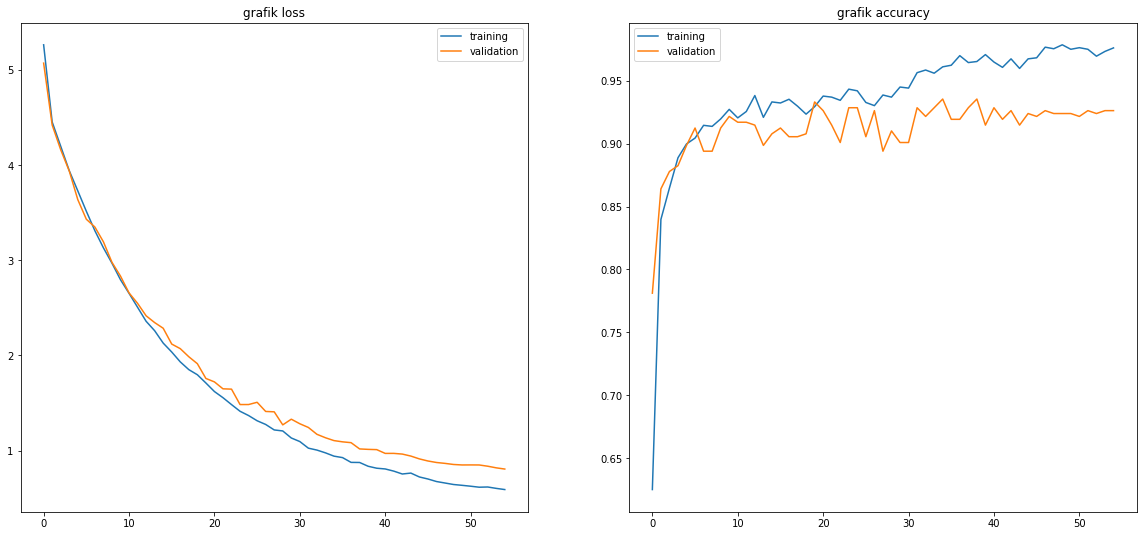

In [58]:
plt.figure(figsize=(20,9))
plt.subplot(121)
plt.title('grafik loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

plt.subplot(122)
plt.title('grafik accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [67]:
np.argmax(history.history['val_accuracy'])

34